## 7.2 Assignment: Create Optimal Hotel Recommendations

Online travel agencies are scrambling to meet the artificial intelligence driven personalization standard set by companies like Amazon and Netflix. In addition, the world of online travel has become a highly competitive space where brands try to capture our attention (and wallet) with recommending, comparing, matching, and sharing. For this assignment, we would like to create the optimal hotel recommendations for Expedia’s users that are searching for a hotel to book. For this assignment, you need to predict which “hotel cluster” the user is likely to book, given his (or her) search details.

The data set can be found at Kaggle: Expedia Hotel Recommendations. To get started, I would suggest exploring the file train.csv, which contains the logs of user behavior.  There is another file named destinations.csv, which contains information related to hotel reviews made by users. There is a lot of data here, and making an accurate prediction is rather difficult, e.g., simply running a standard prediction algorithm will probably yield below 10% accuracy. Start by doing some exploratory analysis of this data to help understand how to make a prediction on the hotel cluster the user is likely to select. Then, split train.csv into a training and test set (feel free to select a smaller random subset of train.csv). Then, build at least two prediction models from the training set, and report the accuracies on the test set. As I mentioned, this is a difficult problem, so be creative with your solutions. You might want to try building your own predictor rather than a standard predictor model, e.g., a random forest.  The purpose of this project is not necessarily to get great results but to understand the nuances and challenges of such problems.

### Data

The dataset for this project can be found on Kaggle \
https://www.kaggle.com/c/expedia-hotel-recommendations/data

### Attributes

#### Training Set


| Column name               | Description                                                                                                               | Data type |
|---------------------------|---------------------------------------------------------------------------------------------------------------------------|-----------|
| date_time                 | Timestamp                                                                                                                 | string    |
| site_name                 | ID of the Expedia point of sale (i.e. Expedia.com, Expedia.co.uk, Expedia.co.jp, ...)                                     | int       |
| posa_continent            | ID of continent associated with site_name                                                                                 | int       |
| user_location_country     | The ID of the country the customer is located                                                                             | int       |
| user_location_region      | The ID of the region the customer is located                                                                              | int       |
| user_location_city        | The ID of the city the customer is located                                                                                | int       |
| orig_destination_distance | Physical distance between a hotel and a customer at the time of search. A null means the distance could not be calculated | double    |
| user_id                   | ID of user                                                                                                                | int       |
| is_mobile                 | 1 when a user connected from a mobile device, 0 otherwise                                                                 | tinyint   |
| is_package                | 1 if the click/booking was generated as a part of a package (i.e. combined with a flight), 0 otherwise                    | int       |
| channel                   | ID of a marketing channel                                                                                                 | int       |
| srch_ci                   | Checkin date                                                                                                              | string    |
| srch_co                   | Checkout date                                                                                                             | string    |
| srch_adults_cnt           | The number of adults specified in the hotel room                                                                          | int       |
| srch_children_cnt         | The number of (extra occupancy) children specified in the hotel room                                                      | int       |
| srch_rm_cnt               | The number of hotel rooms specified in the search                                                                         | int       |
| srch_destination_id       | ID of the destination where the hotel search was performed                                                                | int       |
| srch_destination_type_id  | Type of destination                                                                                                       | int       |
| hotel_continent           | Hotel continent                                                                                                           | int       |
| hotel_country             | Hotel country                                                                                                             | int       |
| hotel_market              | Hotel market                                                                                                              | int       |
| is_booking                | 1 if a booking, 0 if a click                                                                                              | tinyint   |
| cnt                       | Numer of similar events in the context of the same user session                                                           | bigint    |
| hotel_cluster             | ID of a hotel cluster                                                                                                     | int       |

#### Destination Set

| Column name         | Description                                                | Data type |
|---------------------|------------------------------------------------------------|-----------|
| srch_destination_id | ID of the destination where the hotel search was performed | int       |
| d1-d149             | latent description of search regions                       | double    |

### Problem Statement

We are tasked with generating a hotel recommendation system. We will be using the `hotel_cluster` attribute for our target in this project. 

In [1]:
# Standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime

import missingno as mn

# Data Prep
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Models
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint


# Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, plot_confusion_matrix, confusion_matrix

# Block warnings
warnings.simplefilter('ignore')

### Loading in the data

The dataset is very large with over 37M observations. We can reduce the memory consumption by setting the types during import and select only a sample from these observations

In [166]:
# load training data

def load_data(file = "train.csv", nrows = None):
    """"""
    parse_dates = ['date_time','srch_ci','srch_co']
    df = pd.read_csv(file, nrows=nrows,
                    parse_dates=parse_dates,
                    dtype={'site_name':np.int8,
                           'posa_continent':np.int8,
                           'user_location_country':np.int8,
                           'user_location_region':np.int8,
                           'user_location_city':np.int8,
                           'user_id':np.int8,
                           'is_mobile':np.int8,
                           'is_package':np.int8,
                           'channel':np.int8,
                           'srch_destination_id':np.int8,
                           'srch_children_cnt':np.int8,
                           'srch_rm_cnt':np.int8,
                           'srch_adults_cnt':np.int8,
                           'srch_destination_type_id':np.int8,
                           'is_booking':bool,
                           'cnt':np.int8,
                           'hotel_continent':np.int8,
                           'hotel_country':np.int8,
                           'hotel_market':np.int8,
                           'hotel_cluster':np.int8})
    df['srch_co'] = pd.to_datetime(df['srch_co'],errors = 'coerce')
    df['srch_ci'] = pd.to_datetime(df['srch_ci'],errors = 'coerce')
    return df

df = load_data('train.csv', 1000000)

### Data Cleaning and NaN handling

We have a lot of missing values for `orig_destination_distance`. Performing some EDA, we can see that the data is not evenly distributed, likely due to international vs domestic travel and other factors. 

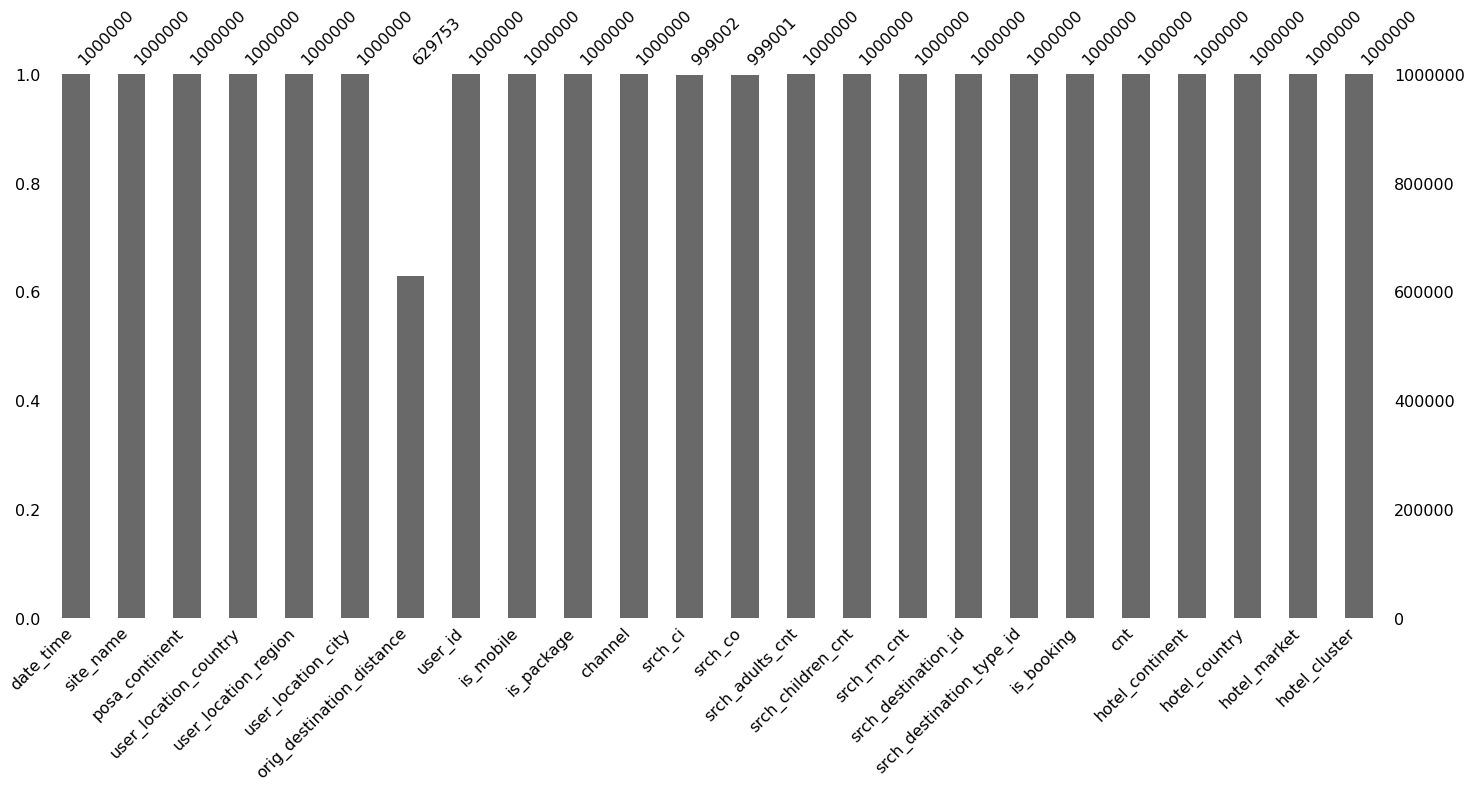

In [194]:
mn.bar(df);

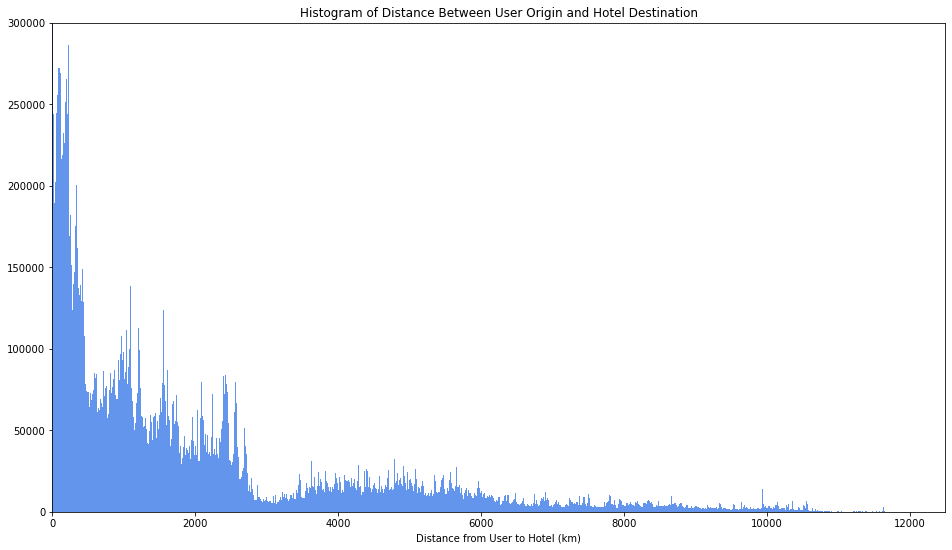

In [241]:
plt.figure(figsize=(16,9))
plt.hist(df['orig_destination_distance'], bins = 1000, color = "cornflowerblue");
plt.ylim(0,300000)
plt.xlim(0,12500)
plt.xlabel("Distance from User to Hotel (km)")
plt.title("Histogram of Distance Between User Origin and Hotel Destination")
plt.show()

We can group together similar obervations and impute this attribute for a few thousand NaN values, but we still have several thousand missing. It's probably best to drop this attribute for our model for this reason

In [42]:
df['orig_destination_distance'].fillna(df.groupby(
    ['user_location_country', 'user_location_region', 'user_location_city',  # Grouping by approximate user location
     'srch_destination_id', 'hotel_continent', 'hotel_country']              # And approximate hotel Location
).agg({'orig_destination_distance':np.nanmedian}).reset_index()['orig_destination_distance'], inplace=True)

#mn.bar(df);

### Feature Engineering

We can use some of the data to create new features in our dataset.

`checkin_year` : Which year the reservation was made for 

`checkin_month` : Which month the reservation was made for 

`checkin_day`: Which day of the week the reservation was made for 

`checkout_day`: Which day of the week the reservation ends 

`nights_stayed`: Number of days reserved at the hotel 

`weekend_getaway`: If the check-in date is on a Friday and the number of days reserved is 3 or less 

`last_minute`: If the hotel was booked the same day as check-in

`short_notice`: If the hotel was booked the same week as check-in 

`mark_your_calenders`: If the hotel was booked more than 2 months out 

`family_vacation`: Checks if 2 or more adults and 1 or more children are reserving a room 

`riding_solo`: If a room is reserved with a single adult and no children (possibly business related) 

`short_trip`: If the number of days stayed is less than or equal to 3 

`down_the_road`: If the user has booked a hotel close by 

`long_distance`: if the hotel is more than 2000 miles away from the user 

`very_long_distance`: If the hotel is more than 6000 miles away from the user

`international_travel`: If the user country and the hotel country do not match 

`its_a_party`: If 6 or more adults book more than 3 rooms for a single night 

`extended_stay`: If the number of days stayed is more than 7 

`romantic_encounter`: If the number of days stayed is less than or equal to 1 and reserved for 2 adults with no children 

`summer_vacation`: If a hotel is reserved through June to August and nights stayed are more than 3 

`winter_vacation`: If a hotel is reserved through December to February and nights stayed are more than 3


The theory in generating attributes such as these is an attempt to evaluate the status of the hotel. For solo travel such as a business trip, it would be common to get a hotel that is within the companies budget. For family trips, themed hotels such as Disney might be booked. A classier hotel might be used for a weekend getaway or a romantic encounter. We are lacking a lot of key attributes like cost and number of stars, so we have to improvise. All these different use cases can be analyzed to help narrow down specific hotel clusters.


In [6]:
df['checkin_year'] = df['srch_ci'].dt.year
df = df.dropna(subset=['checkin_year'])
df['checkin_year'] = df['checkin_year'].apply(int)

df['checkin_month'] = df['srch_ci'].dt.month # might be useful to split into seasons
df['checkin_day'] = df['srch_ci'].dt.weekday
df['checkout_day'] = df['srch_co'].dt.weekday

df['lead_time'] = (df['srch_ci'] - df['date_time']).dt.days
df['nights_stayed'] = (df['srch_co'] - df['srch_ci']).dt.days

# If the reservation was made on a friday and multiple night stayed
df['weekend_getaway'] = np.where((df['nights_stayed']<=3) & 
                                 (df['checkin_day']== 4), 1,0)

# Hotel was booked the same day
df['last_minute'] = np.where((df['lead_time']==0), 1,0)

# Hotel was booked the same week
df['short_notice'] = np.where((df['lead_time']>0) & (df['lead_time']<=7), 1,0)

# Hotel was reserved 2 months in advance
df['mark_the_calender'] = np.where((df['lead_time']>60), 1,0)

# If 2 or more adults were travelling with 1 or more kids
df['family_vacation'] = np.where((df['srch_adults_cnt']>=1) & 
                                (df['srch_children_cnt'] >= 1)& 
                                (df['nights_stayed'] >= 4), 1,0)

# If an adult is traveling alone
df['riding_solo'] = np.where((df['srch_adults_cnt']==1) & 
                             (df['srch_children_cnt']== 0) & 
                             (df['srch_rm_cnt'] == 1),1,0)

# If the trip is less than 4 days
df['short_trip'] = np.where((df['nights_stayed'] <= 3),1,0)

# If the hotel is very close to the user
df['down_the_road'] = np.where((df['orig_destination_distance'] >= 50),1,0)

# If the hotel is far away from the user
df['long_distance'] = np.where((df['orig_destination_distance'] <= 1000),1,0)

# If the hotel is very far away from the user
df['very_long_distance'] = np.where((df['orig_destination_distance'] <= 6000),1,0)

# International Travel
df['international_travel'] = np.where((df['user_location_country'] != df['hotel_country']),1,0)

# If 3 or more rooms are booked for more than 5 people for 1 night
df['its_a_party'] = np.where((df['nights_stayed'] <= 1) & 
                             (df['srch_adults_cnt'] >= 6) & 
                             (df['srch_rm_cnt'] >= 3),1,0)

# If the trip length is more than a week 
df['extended_stay'] = np.where((df['nights_stayed'] > 7),1,0)

# If the hotel was reserved for 1 night or less and for 2 adults and no children
df['romantic_encounter'] = np.where((df['nights_stayed'] <= 1) & 
                                    (df['srch_adults_cnt'] == 2) & 
                                    (df['srch_children_cnt']== 0),1,0)

# If the reservation was in the summer and 1 or more children are on the list and the stay is longer than 3 days
df['summer_vacation'] = np.where((df['checkin_month'] >= 6) &
                                 (df['checkin_month'] <= 8) &
                            #     (df['srch_children_cnt'] >= 1) & 
                                 (df['nights_stayed'] > 3),1,0) 

df['winter_vacation'] = np.where(((df['checkin_month'] <= 2) |
                                 (df['checkin_month'] == 12)) &
                             #    (df['srch_children_cnt'] >= 1) & 
                                 (df['nights_stayed'] > 3),1,0) 

We can also generate some statistics about the hotels and how popular they are using the hotel data to isolate each hotel. By grouping attributes such as `srch_destination_id`,`srch_destination_type_id`, `hotel_country`, and `hotel_market`, we should be able to identify certain regions of hotels. By then counting and summing the `is_booking` attribute, we can see how many clicks and reservations each hotel gets.
\
\
`booking_per_click`: How many bookings there were per engagement \
`clicks_per_booking`: How many clicks there are between bookings \
`total_engagement`: How many clicks and bookings in total were on this category 

and two more attempts at calculating popularity of each genre of hotel.

We can then merge each new column with our dataframe on those same criteria

In [7]:
popularity_df = df.groupby(['srch_destination_id',
                               'srch_destination_type_id',
                               'hotel_country',
                               'hotel_market',
                               'is_package'])['is_booking'].agg(['sum','count']).reset_index()  

popularity_df.rename(columns={'count':'clicks', 'sum':'bookings'}, inplace=True)

# Bookings per Click
popularity_df['booking_per_click'] = popularity_df['bookings'] / (popularity_df['clicks'])

# Clicks per Booking
popularity_df['click_per_booking'] = popularity_df['clicks'] / (popularity_df['bookings'] + 1)

# Number of Bookings + Weighted Clicks
popularity_df['total_engagement'] = (popularity_df['clicks'] * 0.05) + (popularity_df['bookings'])
popularity_df['pop_metric3'] = (popularity_df['clicks']) + (popularity_df['bookings'])

# Total Engagement ** 2
popularity_df['pop_metric4'] = (popularity_df['clicks']) + (popularity_df['bookings']**2)
popularity_df['pop_metric5'] = (popularity_df['clicks']**(-1/2)) + (popularity_df['bookings'])

### EDA

Starting our EDA, using the `time_stamp` attribute, we can see that the usage of Expedia has been going up in recent months.

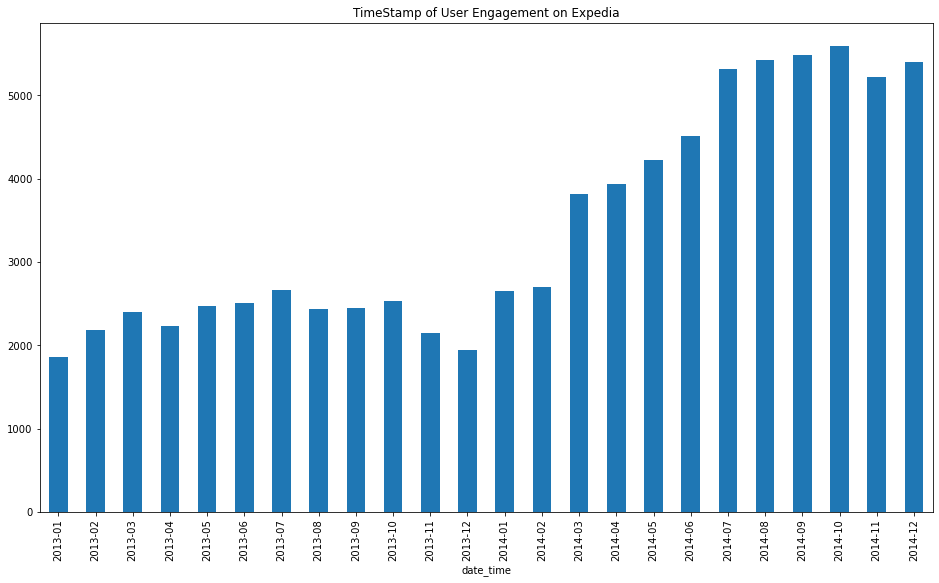

In [8]:
df1 = df.groupby(df['date_time'].dt.to_period('M')).sum()
df1 = df1.resample('M').asfreq().fillna(0)
df1['is_booking'].plot(kind='bar', figsize=(16,9))
plt.title("TimeStamp of User Engagement on Expedia")
plt.show()

We can also use the `srch_ci` attribute to see search results for hotel reservations. We can see a steep drop off around the beginning of 2015, likely due to the data export being done around that time. 

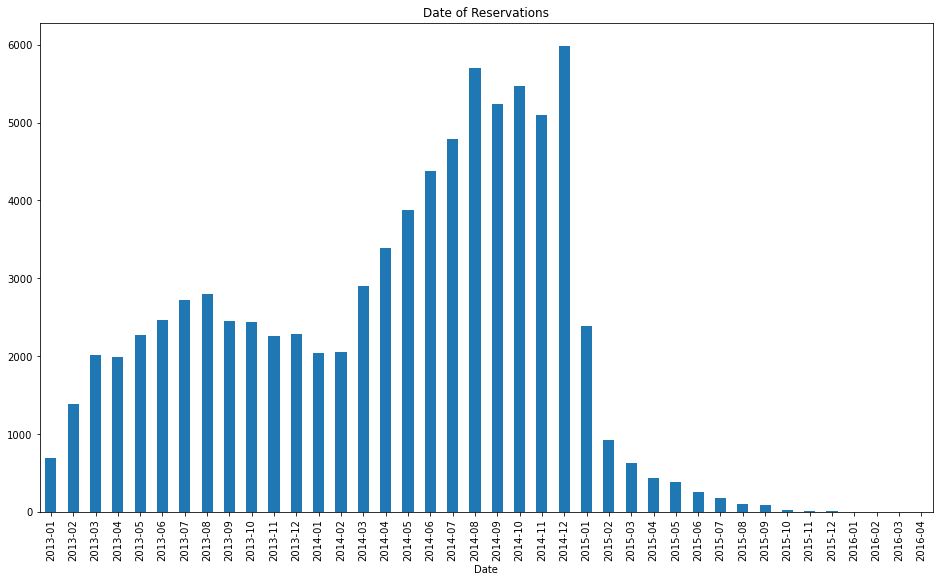

In [9]:
# Couldn't figure out how to set the xlim for datetime using pandas plot so I had to filter

df1 = df[(df['srch_ci']>pd.Timestamp('2012-12-01')) & (df['srch_ci']<pd.Timestamp('2016-06-01'))].groupby(df['srch_ci'].dt.to_period('M')).sum()
df1 = df1.resample('M').asfreq().fillna(0)
df1['is_booking'].plot(kind='bar', figsize=(16,9))
plt.title("Date of Reservations")
plt.xlabel("Date")

df1 = ""

Comparing `time_stamp` with `srch_ci`, we can create a visualization indicating when our users reserve rooms. We have a nice pareto-like distribution, indicating most of our users reserve rooms closer to the reservation date. 

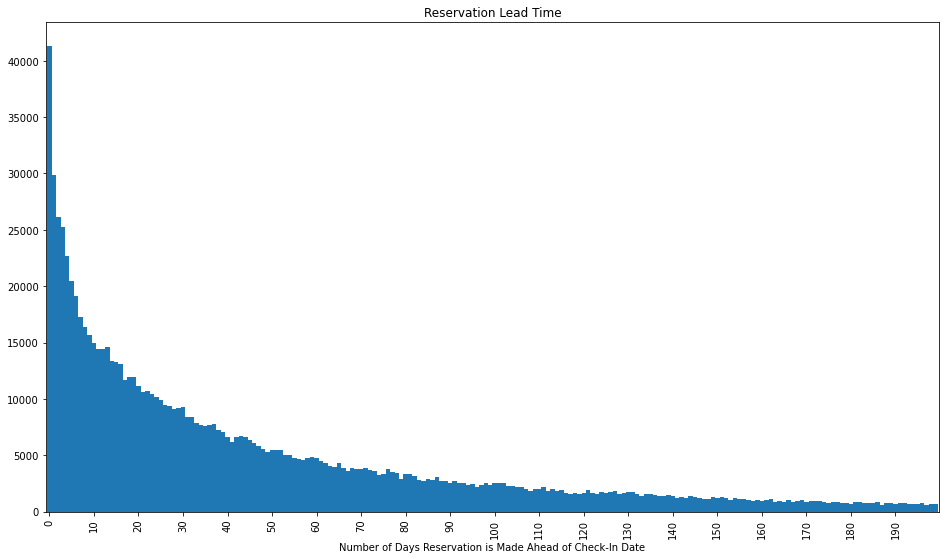

In [10]:
df[(df['lead_time'] >= 0) & (df['lead_time'] < 200)].groupby('lead_time').count()['is_booking'].plot(kind="bar", figsize=(16,9), xticks=(np.arange(0,200,10)), width = 1)
plt.title("Reservation Lead Time")
plt.xlabel("Number of Days Reservation is Made Ahead of Check-In Date")
plt.show()

We can also compare `srch_ci` with `srch_co` to see for how long users are reserving rooms for.

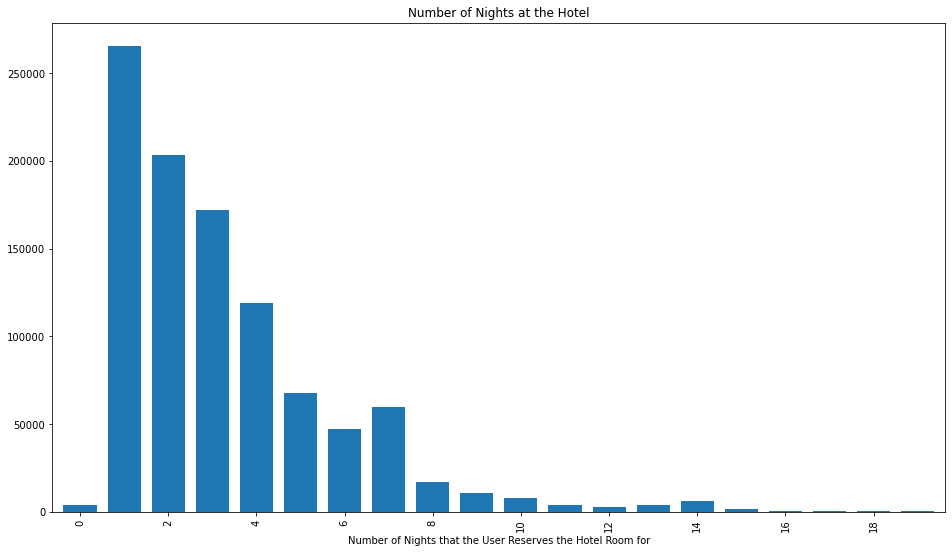

In [11]:
df[(df['nights_stayed'] >= 0) & (df['nights_stayed'] < 20)].groupby('nights_stayed').count()['is_booking'].plot(kind="bar", figsize=(16,9), xticks=(np.arange(0,20,2)), width = 0.75)
plt.title("Number of Nights at the Hotel")
plt.xlabel("Number of Nights that the User Reserves the Hotel Room for")
plt.show()

And using the `srch_ci` and `srch_co` dates, we can see when most users want to arrive and leave the hotel. Friday seems to be the busiest day for check-ins while Sunday seems to be the busiest day for check-outs; an expected phenomenon.

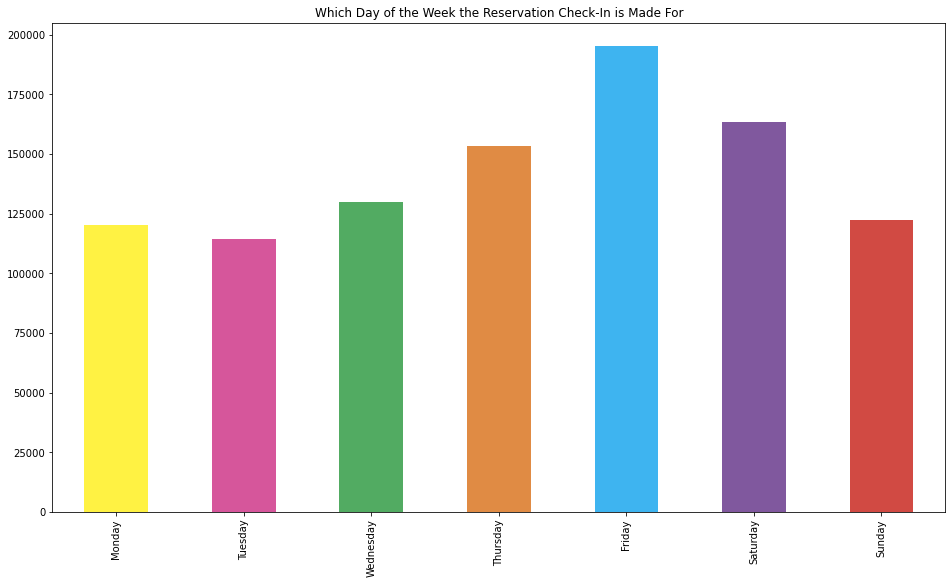

In [12]:
int_to_weekday = {0:"Monday",1:"Tuesday",2:"Wednesday",3:"Thursday",4:"Friday",5:"Saturday", 6:"Sunday"}
df['checkin_day'].dropna().apply(lambda x: int_to_weekday[x]).value_counts()[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']].plot(kind='bar', color = ['#fff243','#d6569b','#52ab62','#e08b44','#3eb4f0','#80589e','#d14a43'], figsize=(16,9))
plt.title("Which Day of the Week the Reservation Check-In is Made For")
plt.show()

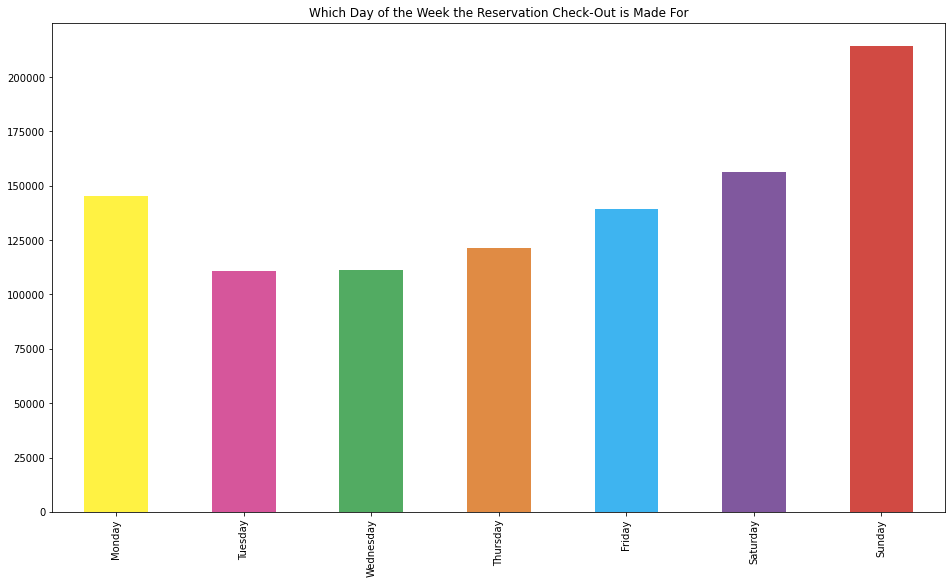

In [13]:
df['checkout_day'].dropna().apply(lambda x: int_to_weekday[x]).value_counts()[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']].plot(kind='bar', color = ['#fff243','#d6569b','#52ab62','#e08b44','#3eb4f0','#80589e','#d14a43'], figsize=(16,9))
plt.title("Which Day of the Week the Reservation Check-Out is Made For")
plt.show()

We can merge in our popularity data with our user data to check which attributes most impact the classification of our hotels. Since we are only interested in predicting which hotels users will actually utilize, we will filter our data by `is_booking == 1`.

In [14]:
df = pd.merge(df, popularity_df, on=['srch_destination_id',
                                     'srch_destination_type_id',
                                     'hotel_country',
                                     'hotel_market',
                                     'is_package'], how='left')

In [15]:
df = df[df['is_booking']==1]

The highest correlated values to `hotel_cluster` seem to be our attempts at generating popularity data with `clicks_per_booking` and `bookings_per_click` as well as `short_trip` and `romantic_encounter`. 

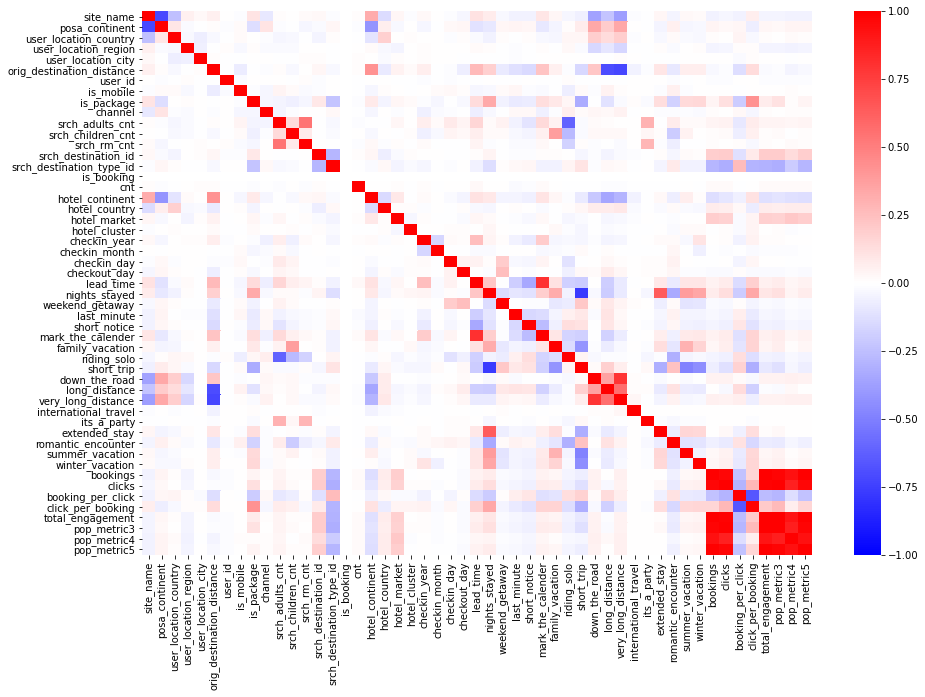

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.heatmap(df.corr(),cmap='bwr', vmin=-1, vmax=1, center=False);

###  Preparing for Modelling
We will want to drop user info like `user_id` and `user_location_city` from our model to prevent overfitting. Since we engineered attributes using the `srch_ci`, `srch_co`, and `date_time`, we will be relying on those. We will also drop `orig_destination_distance` from our list of attributes since there are so many NaN values.

In [17]:
df.drop(['user_id',
            'srch_ci',
            'srch_co',
            'user_location_city',
            'date_time',
            'orig_destination_distance'], axis =1, inplace =True)

We are also given a list of attributes for each search destination. We will merge this in with our prepared dataframe

In [18]:
destination = pd.read_csv("destinations.csv", dtype={'d1':np.float16 , 'd2':np.float16 , 'd3':np.float16 , 'd4':np.float16 , 'd5':np.float16 , 'd6':np.float16 , 'd7':np.float16 , 'd8':np.float16 , 'd9':np.float16 , 'd10':np.float16 , 'd11':np.float16 , 'd12':np.float16 , 'd13':np.float16 , 'd14':np.float16 , 'd15':np.float16 , 'd16':np.float16 , 'd17':np.float16 , 'd18':np.float16 , 'd19':np.float16 , 'd20':np.float16 , 'd21':np.float16 , 'd22':np.float16 , 'd23':np.float16 , 'd24':np.float16 , 'd25':np.float16 , 'd26':np.float16 , 'd27':np.float16 , 'd28':np.float16 , 'd29':np.float16 , 'd30':np.float16 , 'd31':np.float16 , 'd32':np.float16 , 'd33':np.float16 , 'd34':np.float16 , 'd35':np.float16 , 'd36':np.float16 , 'd37':np.float16 , 'd38':np.float16 , 'd39':np.float16 , 'd40':np.float16 , 'd41':np.float16 , 'd42':np.float16 , 'd43':np.float16 , 'd44':np.float16 , 'd45':np.float16 , 'd46':np.float16 , 'd47':np.float16 , 'd48':np.float16 , 'd49':np.float16 , 'd50':np.float16 , 'd51':np.float16 , 'd52':np.float16 , 'd53':np.float16 , 'd54':np.float16 , 'd55':np.float16 , 'd56':np.float16 , 'd57':np.float16 , 'd58':np.float16 , 'd59':np.float16 , 'd60':np.float16 , 'd61':np.float16 , 'd62':np.float16 , 'd63':np.float16 , 'd64':np.float16 , 'd65':np.float16 , 'd66':np.float16 , 'd67':np.float16 , 'd68':np.float16 , 'd69':np.float16 , 'd70':np.float16 , 'd71':np.float16 , 'd72':np.float16 , 'd73':np.float16 , 'd74':np.float16 , 'd75':np.float16 , 'd76':np.float16 , 'd77':np.float16 , 'd78':np.float16 , 'd79':np.float16 , 'd80':np.float16 , 'd81':np.float16 , 'd82':np.float16 , 'd83':np.float16 , 'd84':np.float16 , 'd85':np.float16 , 'd86':np.float16 , 'd87':np.float16 , 'd88':np.float16 , 'd89':np.float16 , 'd90':np.float16 , 'd91':np.float16 , 'd92':np.float16 , 'd93':np.float16 , 'd94':np.float16 , 'd95':np.float16 , 'd96':np.float16 , 'd97':np.float16 , 'd98':np.float16 , 'd99':np.float16 , 'd100':np.float16 , 'd101':np.float16 , 'd102':np.float16 , 'd103':np.float16 , 'd104':np.float16 , 'd105':np.float16 , 'd106':np.float16 , 'd107':np.float16 , 'd108':np.float16 , 'd109':np.float16 , 'd110':np.float16 , 'd111':np.float16 , 'd112':np.float16 , 'd113':np.float16 , 'd114':np.float16 , 'd115':np.float16 , 'd116':np.float16 , 'd117':np.float16 , 'd118':np.float16 , 'd119':np.float16 , 'd120':np.float16 , 'd121':np.float16 , 'd122':np.float16 , 'd123':np.float16 , 'd124':np.float16 , 'd125':np.float16 , 'd126':np.float16 , 'd127':np.float16 , 'd128':np.float16 , 'd129':np.float16 , 'd130':np.float16 , 'd131':np.float16 , 'd132':np.float16 , 'd133':np.float16 , 'd134':np.float16 , 'd135':np.float16 , 'd136':np.float16 , 'd137':np.float16 , 'd138':np.float16 , 'd139':np.float16 , 'd140':np.float16 , 'd141':np.float16 , 'd142':np.float16 , 'd143':np.float16 , 'd144':np.float16 , 'd145':np.float16 , 'd146':np.float16 , 'd147':np.float16 , 'd148':np.float16 , 'd149':np.float16 })
df = pd.merge(df, destination, on="srch_destination_id", how='left')
df.fillna(0, inplace=True)

Splitting our data between X and y. 

In [19]:
X = df.drop(['hotel_cluster'], axis = 1)
y = df['hotel_cluster']

Scaling our data for a neural network. This won't impact our other models. 

In [20]:
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

Splitting data into training and testing datasets

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

### Machine Learning Models

#### K-Nearest Neighbors

In [22]:
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X=X_train,y=y_train)
y_pred_knn = knn_model.predict(X=X_test)

In [23]:
# Accuracy, recall, and precision
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn)*100:.2f}%")
print(f"Precision: {precision_score(y_test, y_pred_knn,average='macro')*100:.2f}%")
print(f"Recall: {recall_score(y_test, y_pred_knn, average='macro')*100:.2f}%")

Accuracy: 5.53%
Precision: 6.33%
Recall: 5.05%


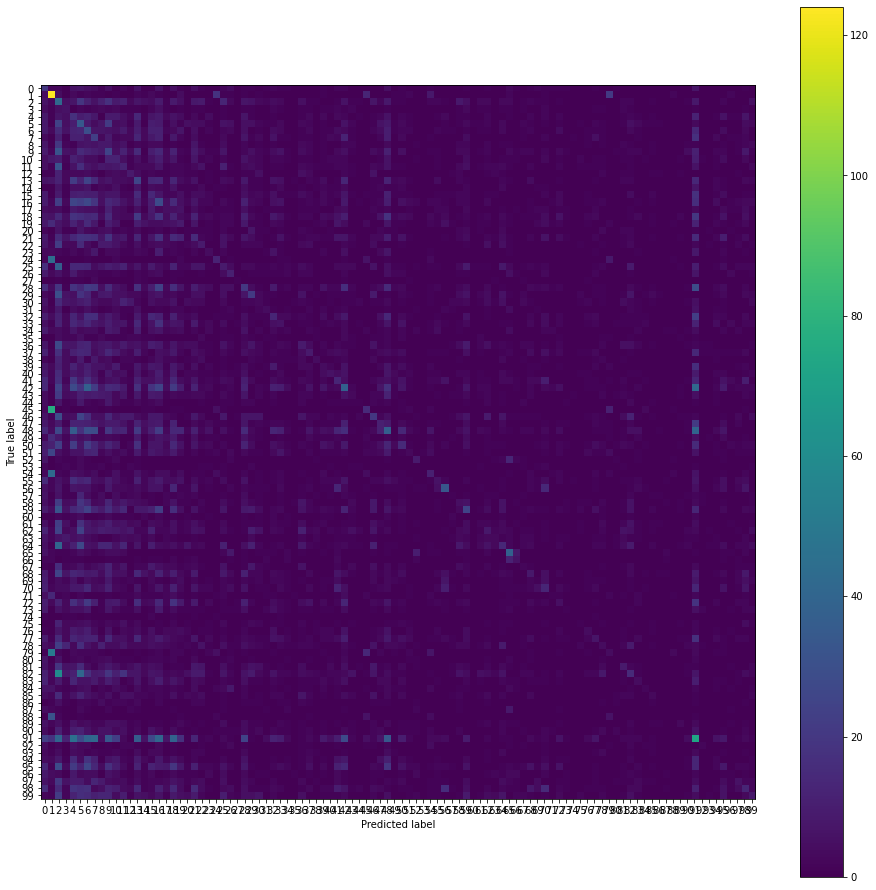

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(16,16)
plot_confusion_matrix(knn_model, X_test, y_test, ax=ax,include_values=False);

#### Decision Tree

In [25]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X=X_train,y=y_train)
y_pred_tree = tree_model.predict(X=X_test)

In [26]:
# Accuracy, recall, and precision
print(f"Accuracy: {accuracy_score(y_test, y_pred_tree)*100:.2f}%")
print(f"Precision: {precision_score(y_test, y_pred_tree,average='macro')*100:.2f}%")
print(f"Recall: {recall_score(y_test, y_pred_tree, average='macro')*100:.2f}%")

Accuracy: 14.87%
Precision: 15.42%
Recall: 15.39%


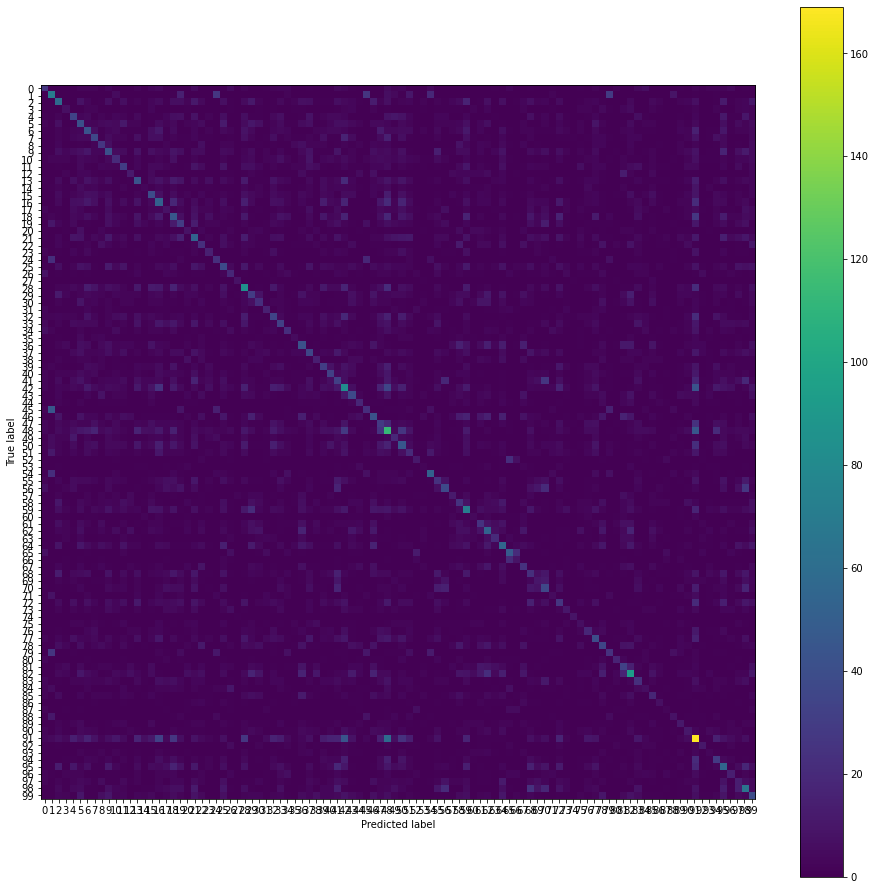

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(16,16)
plot_confusion_matrix(tree_model, X_test, y_test, ax=ax,include_values=False);

#### Random Forest

In [28]:
forest = RandomForestClassifier()
forest.fit(X=X_train,y=y_train)
y_pred_forest = forest.predict(X=X_test)

In [29]:
# Accuracy, recall, and precision
print(f"Accuracy: {accuracy_score(y_test, y_pred_forest)*100:.2f}%")
print(f"Precision: {precision_score(y_test, y_pred_forest,average='macro')*100:.2f}%")
print(f"Recall: {recall_score(y_test, y_pred_forest, average='macro')*100:.2f}%")

Accuracy: 20.26%
Precision: 21.91%
Recall: 20.00%


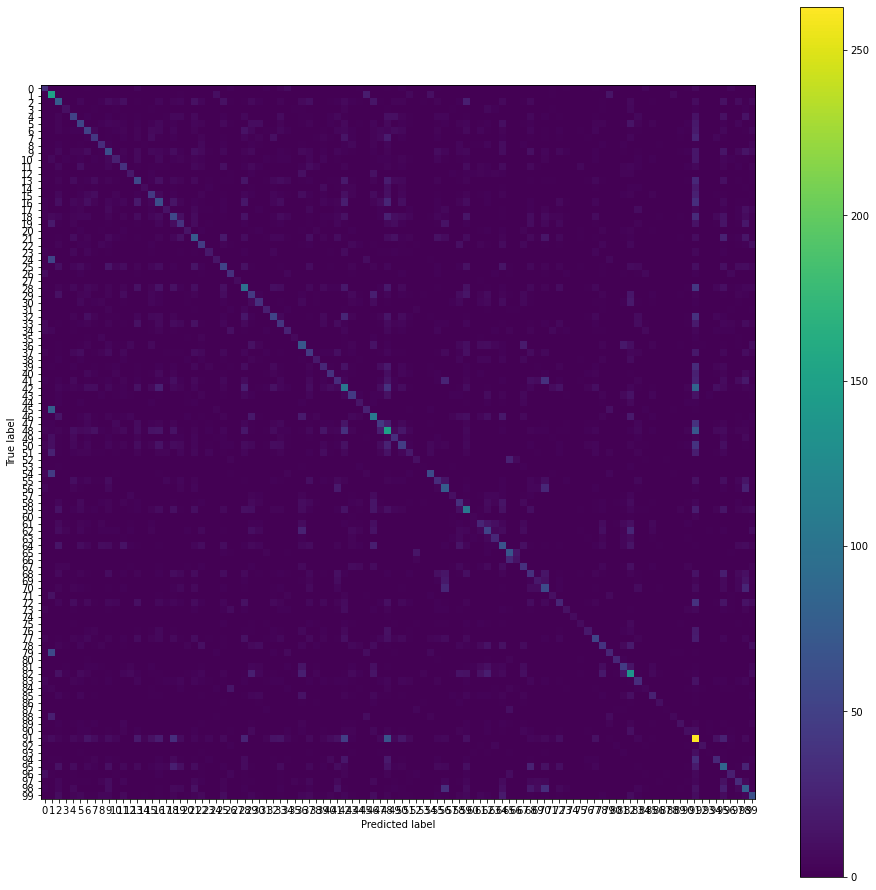

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(16,16)
plot_confusion_matrix(forest, X_test, y_test, ax=ax,include_values=False);

#### Neural Network

We will need to restructure our input attributes to prepare it for neural network training. Categorical data like `site_name`, `posa_continent`, `user_location_country`,`user_location_region`,`srch_destination_id`, `srch_destination_type_id`, `hotel_continent`, `hotel_country`,and `hotel_market` will be given unique categories with each observation containing either a 1 to indicate the criteria has been met or a 0 to indicate it hasn't

In [31]:
X = pd.DataFrame(X, columns=df.drop(['hotel_cluster'], axis = 1).columns)

In [32]:
X = pd.get_dummies(X, columns = ['site_name', 'posa_continent', 'user_location_country',
                                 'user_location_region','srch_destination_id', 'srch_destination_type_id', 
                                 'hotel_continent', 'hotel_country', 'hotel_market', 
                                 'checkin_day', 'checkout_day'])


In [33]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

# convert integers to dummy variables (i.e. one hot encoded)
y = np_utils.to_categorical(encoded_y)
X_train, X_test, y_train, y_test = train_test_split(X, y)


In [34]:
model = Sequential()
model.add(Dense(1024, activation='relu', input_dim=X.shape[1]))
model.add(Dropout(0.5))
#model.add(Dense(2048, activation='relu'))
#model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
callbacks = [EarlyStopping(monitor='val_loss', patience=10),
         ModelCheckpoint(filepath='best_model_cat_comments.h5', monitor='val_loss', save_best_only=True)]
# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              1395712   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2

In [35]:
# Training the model
start = datetime.datetime.now()
print("Operation Started: "+str(start.strftime("%m/%d/%y %H:%M:%S")))
history = model.fit(X_train, 
                    y_train, 
                    batch_size=128, 
                    epochs = 200,
                    callbacks=callbacks,
                    validation_data=(X_test, y_test))
end = datetime.datetime.now()
print("Operation Ended:"+str(end.strftime("%m/%d/%y %H:%M:%S")))
duration = end-start
print(f"Training Time: {str((duration.seconds // 3600)).zfill(2)}:\
{str((duration.seconds // 60)).zfill(2)}:\
{str((duration.seconds % 60)).zfill(2)}")

Operation Started: 04/30/21 21:04:32
Epoch 1/200
482/482 [==============================] - 23s 45ms/step - loss: 4.3351 - accuracy: 0.0446 - val_loss: 3.8215 - val_accuracy: 0.0955
Epoch 2/200
482/482 [==============================] - 20s 41ms/step - loss: 3.8689 - accuracy: 0.0789 - val_loss: 3.6762 - val_accuracy: 0.1051
Epoch 3/200
482/482 [==============================] - 19s 39ms/step - loss: 3.7354 - accuracy: 0.0964 - val_loss: 3.6136 - val_accuracy: 0.1107
Epoch 4/200
482/482 [==============================] - 19s 39ms/step - loss: 3.6734 - accuracy: 0.1000 - val_loss: 3.5647 - val_accuracy: 0.1212
Epoch 5/200
482/482 [==============================] - 19s 39ms/step - loss: 3.6316 - accuracy: 0.1088 - val_loss: 3.5593 - val_accuracy: 0.1206
Epoch 6/200
482/482 [==============================] - 19s 39ms/step - loss: 3.5928 - accuracy: 0.1110 - val_loss: 3.5365 - val_accuracy: 0.1228
Epoch 7/200
482/482 [==============================] - 19s 39ms/step - loss: 3.5681 - accurac

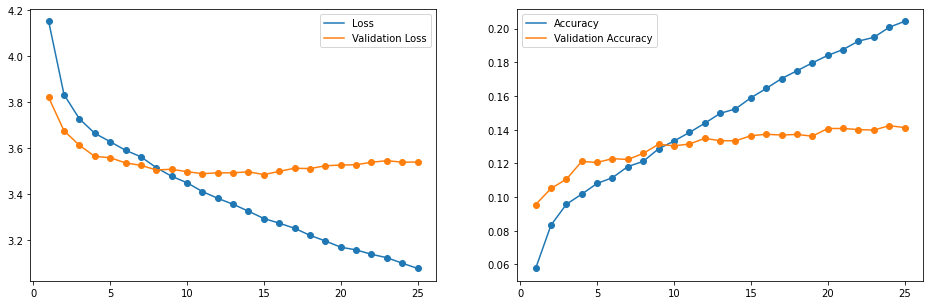

In [36]:
# Plotting the loss and accuracy of the training and testing sets
epochs = len(history.history['loss'])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))

ax1.plot(np.arange(1,epochs+ 1),history.history['loss'], label = 'Loss') 
ax1.plot(np.arange(1,epochs+ 1),history.history['val_loss'], label = 'Validation Loss')
ax1.scatter(np.arange(1,epochs+ 1),history.history['loss']) 
ax1.scatter(np.arange(1,epochs+ 1),history.history['val_loss'])

ax2.plot(np.arange(1,epochs+ 1),history.history['accuracy'], label = 'Accuracy') 
ax2.plot(np.arange(1,epochs+ 1),history.history['val_accuracy'], label = 'Validation Accuracy')

ax2.scatter(np.arange(1,epochs+ 1),history.history['accuracy']) 
ax2.scatter(np.arange(1,epochs+ 1),history.history['val_accuracy'])

ax1.legend()
ax2.legend()
plt.show()

In [37]:
model.evaluate(x = X_test,y = y_test)

642/642 [==============================] - 4s 7ms/step - loss: 3.5403 - accuracy: 0.1413


[3.5403387546539307, 0.14129799604415894]

### Conclusions
The best performing model is the random forest algorithm, which creates multiple decision trees with random initalizations and finds the best pathways to classify each observation. The model achieves up to 21% accuracy on the testing set, which is pretty high compared to the rest of the submissions on the Kaggle leaderboard, factoring out the scores that likely utilized the data leak. 

The second best algorithm was the decision tree algorithm, which had about 15% accuracy. Since the random forest algorithm was so successful, this isn't very suprising.

The third best algorithm was the Keras neural network. After experimenting with several layers, I found that changing the number of hidden layers really didn't impact the accuracy very much. The model seems to be limited at around 14% accuracy. 

The worst performing algorithm was the KNN algorithm. Most of the classificactions fall into the first 20 bins for some reason, possibly indicating that there are too many clusters of hotels. We could try to data mine the data with a K-Means algorithm to find the best number of clusters, since 100 seems to be an arbitrary amount.

### Alternative Methods
Instead of making a model that is based on search criteria for each customer, we can build a psuedo-model that predict hotel clusters based on unique customer profiles. We can group our dataframe by unique customer identifiers like `user_location_country`, `user_location_region`, `user_location_city`, and `user_location_id`. We can then cross reference the locations they have searched for and clicked on to see which clusters they most associate with.

For recurring user instances, we can get up to 60% accuracy using the model on the testing set. We can match up to 95% of the observations in the testing set built from the training set. Unfortunately, the testing set provided by Kaggle has very few repeat user instances from the training set.

In [207]:
# Splitting the data into training and testing sets

df = load_data()
train, test = train_test_split(df, test_size=0.2)


#train = load_data('train.csv')
#test = load_data('test.csv')

In [225]:
# Finding the most commonly booked hotels by unique user ID and search destination. 
df2 = train.groupby(['user_location_country',
                     'user_location_region',
                     'user_location_city',
                     'user_id',
                     'srch_destination_id',
                     'hotel_cluster'])['is_booking'].agg(['count']).reset_index()

df2.sort_values('count', inplace=True)

# Renaming the hotel_cluster column so it won't cause issues during merging
df2.rename(columns={'hotel_cluster':'hotel_cluster_pred'}, inplace=True)

# Keeping only the highest trafficked hotels since we sorted by count. "last" will keep the last entry per hotel and since
# sorted by values, we will keep the highest value
df2 = df2.drop_duplicates(subset=['user_location_country',
                                  'user_location_region',
                                  'user_location_city',
                                  'user_id',
                                  'srch_destination_id'
                                 ], keep="last")
df2.tail()

,user_location_country,user_location_region,user_location_city,user_id,srch_destination_id,hotel_cluster_pred,count
15287817,66,92,-34,11,-81,87,161
4260032,3,49,111,116,28,46,166
4397330,3,50,71,-54,58,45,168
11475921,66,-36,17,124,58,51,170
2638881,-51,98,-29,-20,58,1,186


In [226]:
# Merge the data back together on those same attributes
test2 = pd.merge(test, df2, on = ['user_location_country',
                                 'user_location_region',
                                 'user_location_city',
                                 'user_id',
                                 'srch_destination_id'
                                 ])

In [227]:
# Filtering by bookings only to verify our results 
test2= test2[test2['is_booking']==1]

In [228]:
# Accuracy
np.mean(test2['hotel_cluster'] == test2['hotel_cluster_pred'])

0.5946286892768681

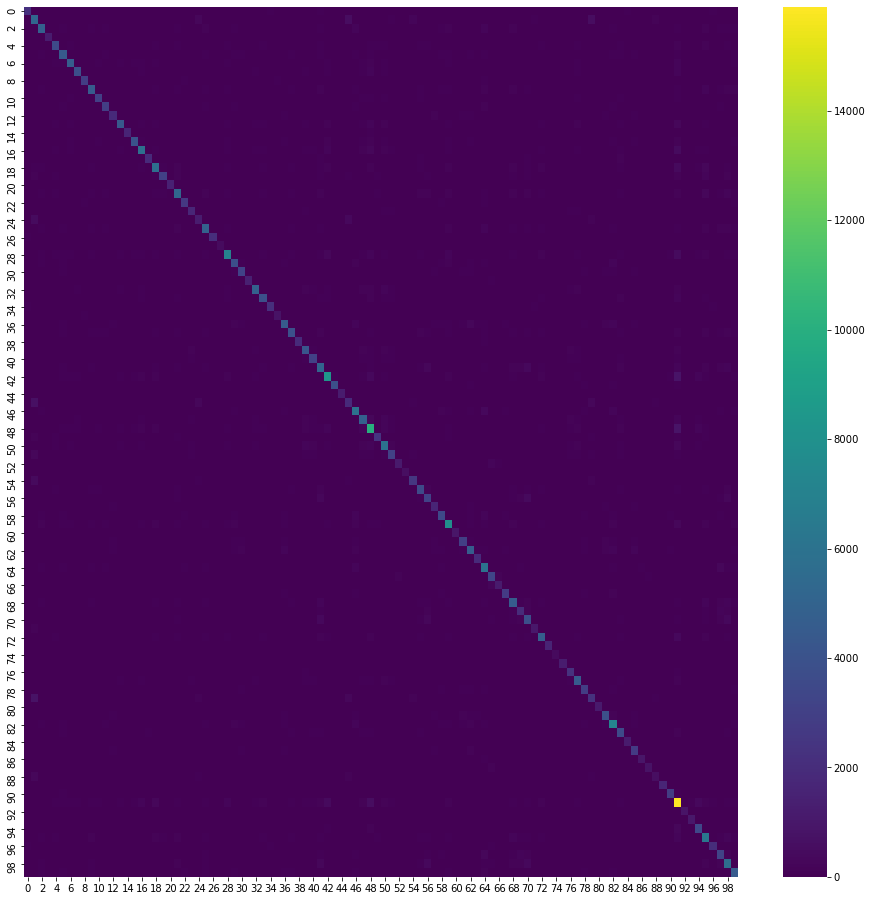

In [229]:
cm = confusion_matrix(test2['hotel_cluster'], test2['hotel_cluster_pred'])

fig, ax = plt.subplots()
fig.set_size_inches(16,16)
sns.heatmap(cm, cmap="viridis", ax = ax);

In [230]:
# Merge the data back together on those same attributes
test2 = pd.merge(test, df2, on = ['user_location_country',
                                 'user_location_region',
                                 'user_location_city',
                                 'user_id',
                                 'srch_destination_id'
                                 ], how = 'left')

In [231]:
# Filtering by bookings only to verify our results 
test2= test2[test2['is_booking']==1]

Found match for 94.06% of observations


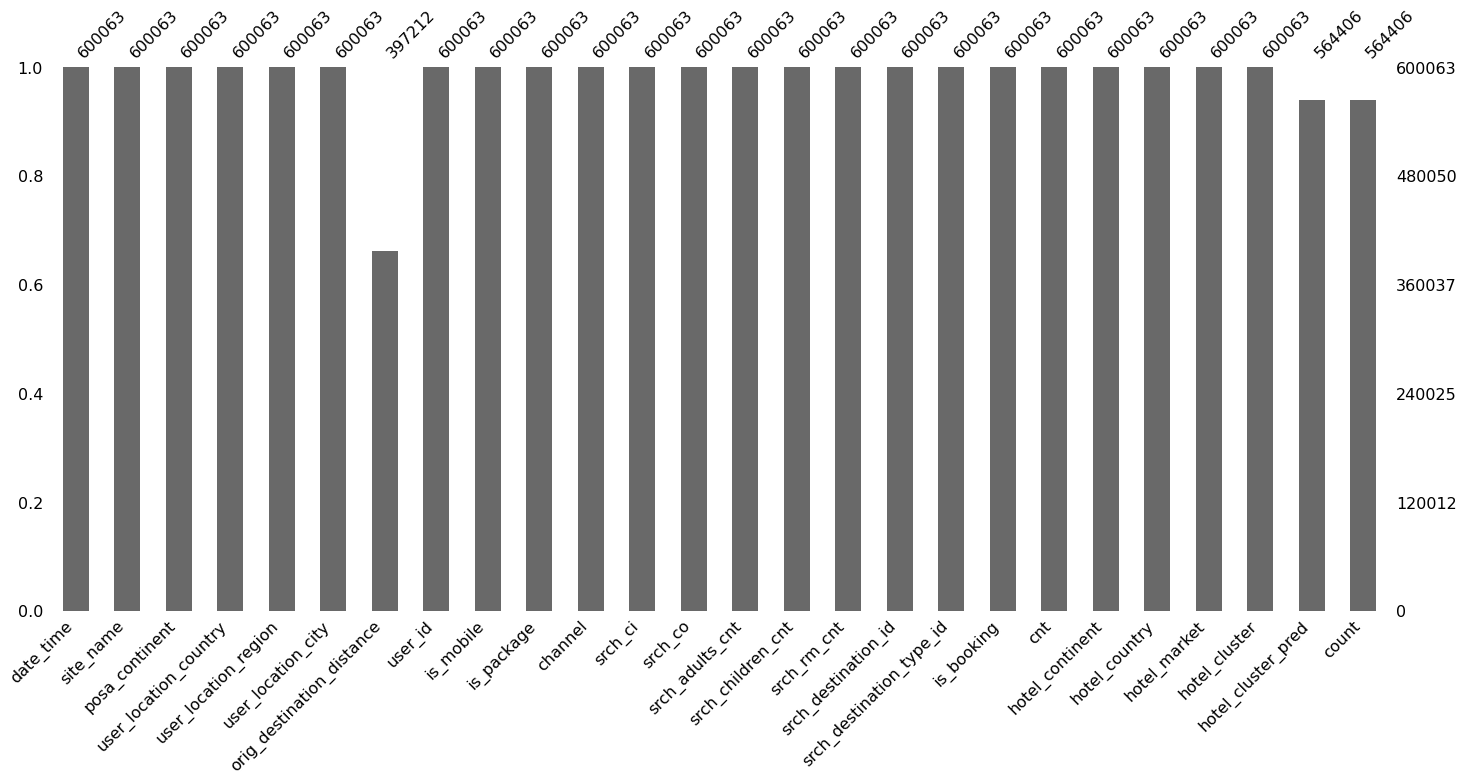

In [238]:
mn.bar(test2)
print(f"Found match for {100 - (100 * test2['hotel_cluster_pred'].isna().sum()) / len(test2):.2f}% of observations")